# Разработка A/B-тестирования и анализ результатов

Компания разрабатывает развлекательное приложение с функцией «бесконечной» ленты, наподобие TikTok. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Работаем с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Задачи: 
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработаем с историческими данными приложения

In [1]:
# Импортируем библиотеку pandas
import pandas as pd

In [2]:
# Импортируем модуль ttest_ind из библиотеки scipy.stats
from scipy.stats import ttest_ind

In [3]:
# Импортируем функцию proportions_ztest из пакета statsmodels.stats.proportion
from statsmodels.stats.proportion import proportions_ztest

In [4]:
# Считаем и сохраним в датафрейм sessions_history CSV-файл с историческими данными о сессиях пользователей
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [5]:
# Выведем на экран первые пять строк полученного датафрейма
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [6]:
# Для каждого уникального пользователя user_id рассчитаем количество уникальных сессий
sessions_history.groupby('user_id').session_id.nunique()

user_id
00005FB6A13A6FBE    2
0000B15A18D77ED9    3
0000C4E3A4A571A9    2
000293FAF9E67A81    4
00029C5AE889A6C3    2
                   ..
FFFCDE7746148710    4
FFFDD413285E753F    3
FFFECBA0F2578AB0    2
FFFEDB68228B5F21    5
FFFF4228DF580C3B    3
Name: session_id, Length: 134039, dtype: int64

In [7]:
# Найдем id пользователя с наибольшим количеством сессий
top_session_user_id = sessions_history.groupby('user_id').session_id.nunique().idxmax()

In [8]:
# Выведем на экран все данные из таблицы sessions_history для пользователя с наибольшим количеством сессий
sessions_history[sessions_history.user_id == top_session_user_id]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Видим, что сессии пронумерованы по порядку в завсимости от время начала сессии. Каждая сессия насчитывает определенное количество просмотренных страниц. Авторизация, регион и устройство и пользователя во всех сессиях остались прежними.

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты будем считать, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [9]:
# Создадим сводную таблицу с числом уникальных и зарегистрированных пользователей для каждого дня наблюдения
pivot_table1 = sessions_history.pivot_table(
    values = ['user_id', 'registration_flag'],
    index = 'session_date',
    aggfunc = {
        'user_id': 'nunique',
        'registration_flag': 'sum'
    }
)

In [10]:
# Импортируем модуль pyplot библиотеки matplotlib
import matplotlib.pyplot as plt

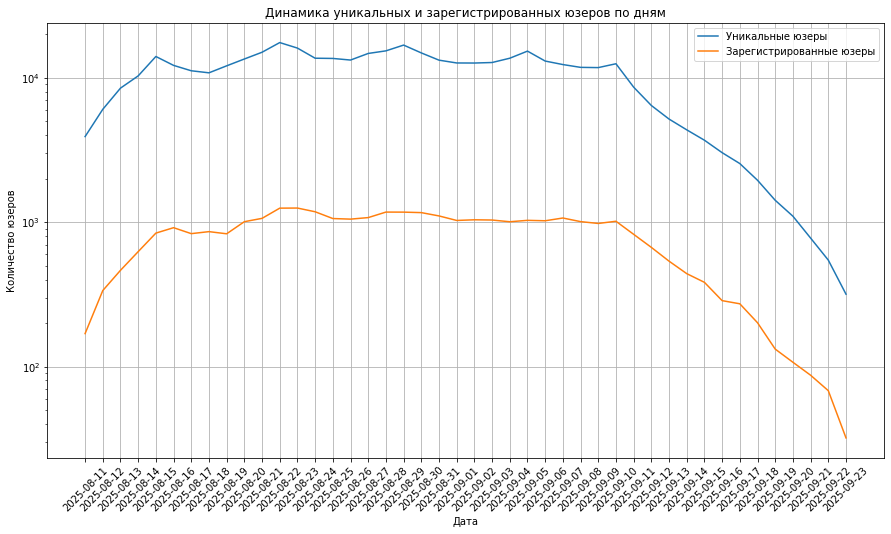

In [11]:
# Построим линейные графики общего числа пользователей и 
# общего числа зарегистрированных пользователей по дням на одном графике
plt.figure(figsize=(15, 8))
plt.plot(pivot_table1.user_id, label ='Уникальные юзеры')
plt.plot(pivot_table1.registration_flag,label ='Зарегистрированные юзеры')

plt.xlabel('Дата')
plt.ylabel('Количество юзеров')
plt.legend()
plt.title('Динамика уникальных и зарегистрированных юзеров по дням')
plt.yscale("log") # Сделаем логарифмическую шкалу для большей наглядности
plt.xticks(rotation=45)
plt.grid()
plt.show()

Динамика уникальных и зарегистрированных юзеров по дням с 11 августа по 23 сентября схожа.

In [12]:
# Создадим столбец с долей зарегистрированных пользователей от всех пользователей 
pivot_table1['reg_users_share'] = pivot_table1.registration_flag / pivot_table1.user_id

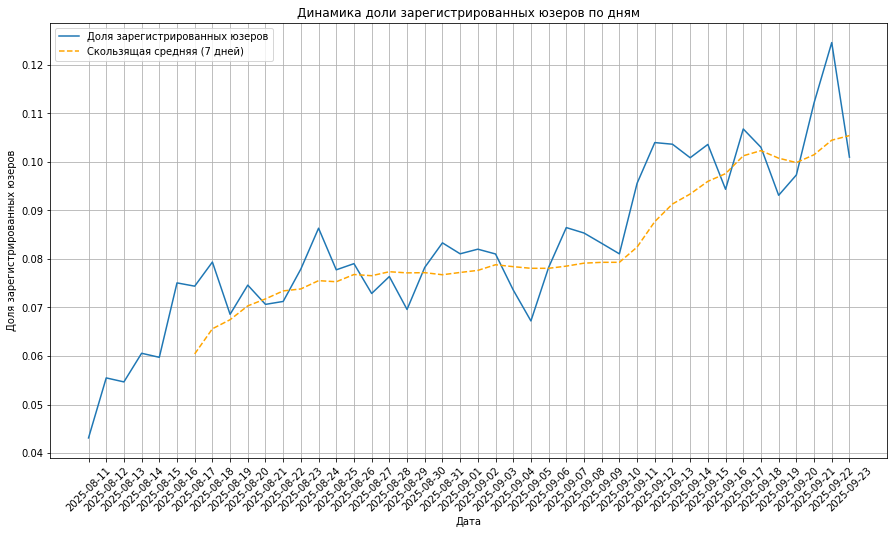

In [13]:
# Построим  линейный график доли зарегистрированных пользователей от всех пользователей по дням
plt.figure(figsize=(15, 8))
plt.plot(pivot_table1.reg_users_share, label ='Доля зарегистрированных юзеров')

# Добавим на график скользящую среднюю по 7 дням
pivot_table1['reg_users_share_rolling_7'] = pivot_table1['reg_users_share'].rolling(window=7).mean()
plt.plot(pivot_table1.reg_users_share_rolling_7, label='Скользящая средняя (7 дней)', linestyle='--', color='orange')

plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных юзеров')
plt.title('Динамика доли зарегистрированных юзеров по дням')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

Доля зарегистрированных пользователей от всех пользователей постепенно растет в рассматриваемом периоде. Активный рост начался после 9 сентября.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц.

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

In [14]:
# Найдем количество сессий для каждого значения количества просмотренных страниц
count_sessions = sessions_history.groupby('page_counter').session_id.nunique()
count_sessions

page_counter
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: session_id, dtype: int64

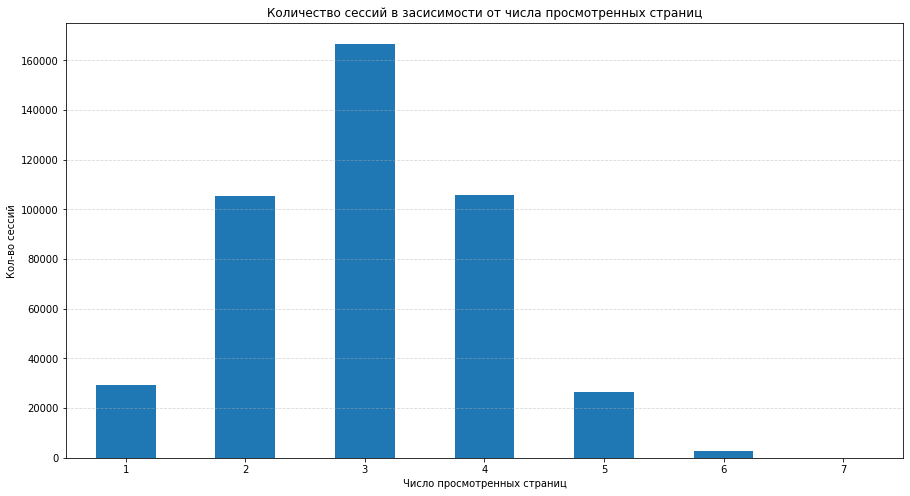

In [15]:
# Построим столбчатую диаграмму

plt.figure(figsize=(15, 8))
count_sessions.plot(kind = 'bar')

plt.xlabel('Число просмотренных страниц')
plt.ylabel('Кол-во сессий')
plt.title('Количество сессий в засисимости от числа просмотренных страниц')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

В большей части сессий просматривается 3 страницы. Распределение числа просмотренных страниц нормальное. 

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [16]:
# Создадим дополнительный столбец good_session и заполним его по условию
sessions_history['good_session'] = 0
sessions_history.loc[sessions_history['page_counter'] >= 4, 'good_session'] = 1

In [17]:
# Агрегируем данные, чтобы рассчитать долю успешных сессий 
agg_good = sessions_history.groupby('session_date').agg({
    'session_id': 'nunique',
    'good_session': 'sum'
})

In [18]:
# Создадим столбец для рассчета доли успешных сессий 
agg_good['good_session_share'] = agg_good.good_session / agg_good.session_id

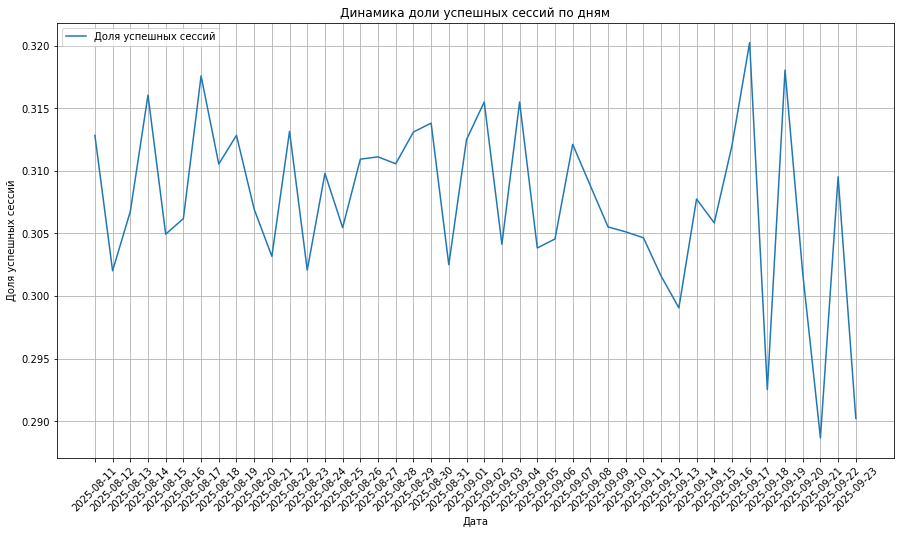

In [19]:
# Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

plt.figure(figsize=(15, 8))
plt.plot(agg_good['good_session_share'], label ='Доля успешных сессий')

plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.title('Динамика доли успешных сессий по дням')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

Доля успешных сессий стабильна в рассматриваемом периоде (29-32%), есть незначительные колебания в рамках 3%. 

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы.

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

За целевую метрику возьмем __долю успешных сессий в день__. Если были бы данные о длительности сессий, то можно было рассмотреть еще среднее время сессии пользователя за день. 

Сформулируем нулевую и альтернативную гипотезы:

* H0: Доля успешных сессий в день в контрольной группе не отличается от показателя в тестовой группе.

* H1: Доля успешных сессий в день у пользователей в тестовой группе больше, чем в контрольной группе, во время проведения теста.





#### 2.2. Расчёт размера выборки

Для расчета размера выборки установим в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [20]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1-beta  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определим длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения.

In [21]:
# Рассчитаем среднее количество уникальных пользователей приложения в день
sessions_history.groupby('session_date').user_id.nunique()

session_date
2025-08-11     3919
2025-08-12     6056
2025-08-13     8489
2025-08-14    10321
2025-08-15    14065
2025-08-16    12205
2025-08-17    11200
2025-08-18    10839
2025-08-19    12118
2025-08-20    13514
2025-08-21    15051
2025-08-22    17563
2025-08-23    16082
2025-08-24    13683
2025-08-25    13635
2025-08-26    13289
2025-08-27    14766
2025-08-28    15388
2025-08-29    16873
2025-08-30    14891
2025-08-31    13266
2025-09-01    12685
2025-09-02    12672
2025-09-03    12777
2025-09-04    13683
2025-09-05    15324
2025-09-06    13078
2025-09-07    12367
2025-09-08    11826
2025-09-09    11780
2025-09-10    12526
2025-09-11     8623
2025-09-12     6436
2025-09-13     5183
2025-09-14     4364
2025-09-15     3698
2025-09-16     3032
2025-09-17     2548
2025-09-18     1952
2025-09-19     1418
2025-09-20     1100
2025-09-21      776
2025-09-22      546
2025-09-23      317
Name: user_id, dtype: int64

In [22]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
# округляем в большую сторону, потому что пользователи корректно описывать целым числом
avg_daily_users = ceil(sessions_history.groupby('session_date').user_id.nunique().mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9908 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первый день. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие нас метрики корректно считаются.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. Построим визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [23]:
# Считаем и сохраним в датафрейм sessions_test_part CSV-файл с историческими данными о сессиях пользователей
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [24]:
# Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения
users_by_test_groups = sessions_test_part.groupby(['test_group','session_date']).user_id.nunique()

In [25]:
# Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B
percent_difference = round(100.0 * (users_by_test_groups.iloc[0] - users_by_test_groups.iloc[1]) / users_by_test_groups.iloc[0], 3)
print(f'Процентная разница между количеством пользователей в группах А и В составила {percent_difference}% ({users_by_test_groups.iloc[0] - users_by_test_groups.iloc[1]} пользователей)')

Процентная разница между количеством пользователей в группах А и В составила 0.745% (11 пользователей)


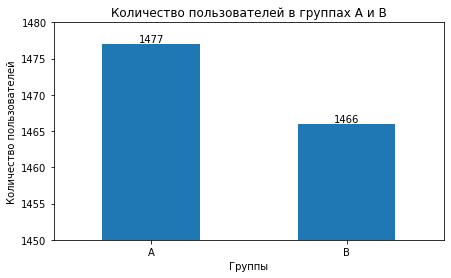

In [26]:
# Построим столбчатую диаграмму, на которой будет видно различие двух групп
plt.figure(figsize=(7, 4))
ax = users_by_test_groups.plot(kind = 'bar')

# Добавление подписей над столбцами
for x, y in enumerate(users_by_test_groups):
    ax.text(x, y, str(y), ha='center', va='bottom', fontsize=10)

plt.xlabel('Группы')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей в группах А и В')
plt.xticks([0, 1], ['A', 'B'], rotation=0)
plt.ylim(1450, 1480)
plt.show()

Процентная разница между количеством пользователей в группах А и В составила 0.745% (11 пользователей). Различие незначительное, можем далее проводить A/B тест. Сделаем проверку пересечений пользователей.

#### 3.2. Проверка пересечений пользователей
Убедимся в том, что никто из пользователей случайно не попал в обе группы одновременно.

In [19]:
# Рассчитаем количество пользователей в группах A и B
a_group = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
b_group = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

# Найдем пересечения
intersection = len(set(a_group) & set(b_group))

print(f'Количество юзеров, попавших в обе группы: {intersection}')

NameError: name 'sessions_test_part' is not defined

In [28]:
sessions_test_part.groupby('user_id').test_group.nunique().sort_values(ascending = False)

user_id
00079359B9D3C6F7    1
ADC2E1E1158CFBB2    1
ADCEEDAD20F4782F    1
ADDCDDC883993FA6    1
AE072C4F9B473BCD    1
                   ..
54C3FA4C32B6ABBA    1
54F28A45A5E77DB8    1
54FF42B690A9B2E5    1
55529D5E3198D24D    1
FFFCDE7746148710    1
Name: test_group, Length: 2943, dtype: int64

Пользователей, попавших одновременно в обе группы, нет. Группы независимы. 

#### 3.3. Равномерность разделения пользователей по устройствам
Убедимся в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.


In [29]:
# Агрегируем данные, получим кол-во уникальных пользователей по группам и устройствам
agg_dev = sessions_test_part.groupby(['test_group','device']).user_id.nunique().reset_index()

In [30]:
# Создадим новый столбец и рассчитаем в нем долю каждого типа устройства для пользователей из групп А и В
agg_dev['users_share'] = 0
agg_dev.loc[agg_dev.test_group == 'A', 'users_share'] = round(agg_dev[agg_dev.test_group == 'A']['user_id'] / a_group.nunique(), 3)
agg_dev.loc[agg_dev.test_group == 'B', 'users_share'] = round(agg_dev[agg_dev.test_group == 'B']['user_id'] / b_group.nunique(), 3)

In [31]:
# Для удобства построения диаграмм разделим агрегированный датафрейм в зависимости от группы
agg_devA = agg_dev[agg_dev.test_group == 'A'].drop(columns={'test_group'}).set_index('device')
agg_devB = agg_dev[agg_dev.test_group == 'B'].drop(columns={'test_group'}).set_index('device') 

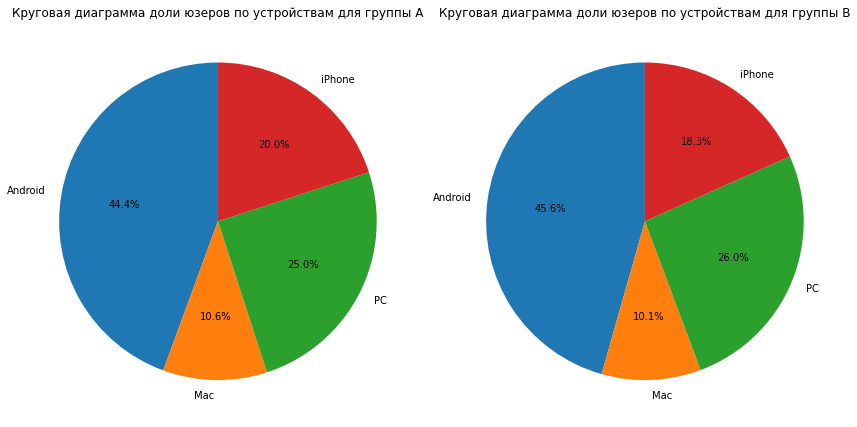

In [32]:
# Создаём два подграфика рядом
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# График для группы A
axes[0].pie(agg_devA['users_share'], labels=agg_devA.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Круговая диаграмма доли юзеров по устройствам для группы A')

# График для группы B
axes[1].pie(agg_devB['users_share'], labels=agg_devB.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Круговая диаграмма доли юзеров по устройствам для группы B')

plt.tight_layout()
plt.show()

Круговые диаграммы позволяют сделать вывод о том, что распределение  устройств в группах A и B совпадает.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

In [33]:
# Агрегируем данные, получим кол-во уникальных пользователей по группам и регионам
agg_reg = sessions_test_part.groupby(['test_group','region']).user_id.nunique().reset_index()

In [34]:
# Создадим новый столбец и рассчитаем в нем долю каждого региона для пользователей из групп А и В
agg_reg['users_share'] = 0
agg_reg.loc[agg_reg.test_group == 'A', 'users_share'] = round(agg_reg[agg_reg.test_group == 'A']['user_id'] / a_group.nunique(), 3)
agg_reg.loc[agg_reg.test_group == 'B', 'users_share'] = round(agg_reg[agg_reg.test_group == 'B']['user_id'] / b_group.nunique(), 3)

In [35]:
# Для удобства построения графиков разделим агрегированный датафрейм в зависимости от группы
agg_regA = agg_reg[agg_reg.test_group == 'A'].drop(columns={'test_group'}).set_index('region')
agg_regB = agg_reg[agg_reg.test_group == 'B'].drop(columns={'test_group'}).set_index('region') 

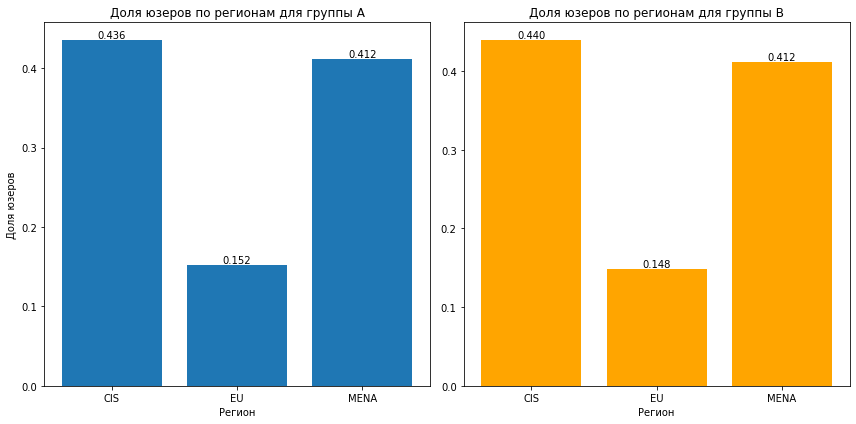

In [36]:
# Создаём два подграфика рядом
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# График для группы A
bars_a = axes[0].bar(agg_regA.index, agg_regA['users_share'])
axes[0].set_title('Доля юзеров по регионам для группы A')
axes[0].set_ylabel('Доля юзеров')
axes[0].set_xlabel('Регион')

# Добавляем подписи над столбцами
for bar in bars_a:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# График для группы B
bars_b = axes[1].bar(agg_regB.index, agg_regB['users_share'], color='orange')
axes[1].set_title('Доля юзеров по регионам для группы B')

axes[1].set_xlabel('Регион')

# Добавляем подписи над столбцами
for bar in bars_b:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    
plt.tight_layout()
plt.show()

Доли пользователей по регионам в обеих группах практически одинаковы.

#### 3.5. Вывод после проверки A/B-теста

__На основе проведённого анализа A/B-теста можно сделать следующие выводы:__
* Процентная разница между количеством пользователей в группах А и В составила 0.745% (11 пользователей). Различие незначительное.
* Пользователей, попавших одновременно в обе группы, нет. Группы независимы. 
* Распределение пользователей по устройствам и регионам в группах A и B совпадает. 

A/B-тест проходит корректно.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [37]:
# Считаем и сохраним в датафрейм sessions_test CSV-файл с историческими данными о сессиях пользователей
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [38]:
# Создадим дополнительный столбец good_session и заполним его по условию
sessions_test['good_session'] = 0
sessions_test.loc[sessions_test['page_counter'] >= 4, 'good_session'] = 1

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будем сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используем  Т-тест для двух выборок, который позволит сделать вывод о равенстве средних.

In [39]:
# Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку
sessions_by_groups = sessions_test.groupby(['session_date', 'test_group']).session_id.nunique().reset_index()

Сформулируем нулевую и альтернативную гипотезы:

* H0: Количество уникальных дневных сессий в двух выборках не различается, или различия статистически не значимы.

* H1: Различия в количестве уникальных дневных сессий в двух выборках есть, и они статистически значимы.

In [40]:
# Для расчета значимости различий в кол-ве уникальных сессий разделим агрегированный датафрейм в зависимости от группы
sessions_A = sessions_by_groups[sessions_by_groups.test_group == 'A'].drop(columns={'test_group'}).set_index('session_date').session_id
sessions_B = sessions_by_groups[sessions_by_groups.test_group == 'B'].drop(columns={'test_group'}).set_index('session_date').session_id

In [41]:
# Рассчитываем критерий Стьюдента для двух выборок 
test_result = ttest_ind(sessions_A, sessions_B)

# Задаем уровень значимости 0.05
alpha = 0.05

if test_result.pvalue > alpha:
    print(f'pvalue={test_result.pvalue} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print(f'pvalue={test_result.pvalue} < {alpha}')
    print('Отвергаем нулевую гипотезу') 

pvalue=0.938219304859116 > 0.05
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу, то есть различие в количестве дневных сессий в группах А и В статистически незначимы. При этом p-value очень высокое, можно говорить, что выборки идентичны. 

#### 4.3. Сравнение доли успешных сессий

Можно переходить к анализу ключевой метрики — доли успешных сессий.


In [42]:
# Рассчитаем долю успешных сессий для выборки A
good_sessions_A = sessions_test[sessions_test.test_group == 'A'].good_session.sum()
num_sessions_A = sessions_test[sessions_test.test_group == 'A'].session_id.nunique()
good_sessions_share_A = round(100.0*good_sessions_A / num_sessions_A, 2)
print(f'Доля успешных сессий для выборки A: {good_sessions_share_A}%')

Доля успешных сессий для выборки A: 30.77%


In [43]:
# Рассчитаем долю успешных сессий для выборки B
good_sessions_B = sessions_test[sessions_test.test_group == 'B'].good_session.sum()
num_sessions_B = sessions_test[sessions_test.test_group == 'B'].session_id.nunique()
good_sessions_share_B = round(100.0*good_sessions_B / num_sessions_B, 2)
print(f'Доля успешных сессий для выборки B: {good_sessions_share_B}%')

Доля успешных сессий для выборки B: 31.83%


In [44]:
good_sessions_share_diff = round(good_sessions_share_B - good_sessions_share_A,1)
print(f'Разница долей успешных сессий для выборок A и B: {good_sessions_share_diff} процентных пункта (в тестовой выборке B показатель выше, чем в контрольной выборке А)')

Разница долей успешных сессий для выборок A и B: 1.1 процентных пункта (в тестовой выборке B показатель выше, чем в контрольной выборке А)


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной.

- Используя Z-тест пропорций, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

Будем использовать Z-тест пропорций, так как именно этот тест позволяет определить, существует ли значимая разница между долями в двух независимых выборках. 
Для начала проверим, выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок. Для этого посчитаем количество наблюдений в каждой группе, а также — количество «успехов» в них. Убедимся, что условия для проведения теста выполнены.

In [45]:
# Проверим, выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок
n_a, n_b = num_sessions_A, num_sessions_B # размеры выборок A и B
m_a = good_sessions_A # количество успехов в группе A
m_b = good_sessions_B # количество успехов в группе B

p_a, p_b = m_a/n_a, m_b/n_b # рассчитываем доли успехов для каждой группы: A и B

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')

print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=49551, n_b=50454
m_a=15248, m_b=16059
p_a=0.3077233557344958, p_b=0.31828992745867524
Предпосылка о достаточном количестве данных выполняется!


__Сформулируем нулевую и альтернативную гипотезы:__

* H0: Доли успешных сессий в двух выборках не различаются, или различия статистически не значимы.

* H1: В тестовой выборке B доля успешных сессий выше, чем в контрольной выборке А, и различие статистически значимо.

In [46]:
alpha = 0.05 # задаем уровень значимости

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения!


В тестовой выборке B доля успешных сессий выше на 1.1%, чем в контрольной выборке А, и различие статистически значимо, так как по итогам Z-теста пропорций p-value меньше уровня значимости.

#### 4.5. Вывод по результатам A/B-эксперимента

Чтобы проверить гипотезу о том, что новый алгоритм рекомендаций будет показывать более интересный контент, были  рассчитаны параметры A/B-теста.


Исторические данные предоставлены за период с 9 августа по 23 сентября 2025.
Даты проведения теста: 14 октября 2025 - 2 ноября 2025.


Чтобы начать тест, было необходимо выяснить, подходят ли данные для его проведения. 

__Анализ исторических данных__:
* Динамика уникальных и зарегистрированных юзеров по дням схожа. 
* Доля зарегистрированных пользователей от всех пользователей постепенно растет в рассматриваемом периоде.
* Распределение числа просмотренных страниц нормальное. 
* Доля успешных сессий стабильна (29-32%), есть незначительные колебания в рамках 3%. 


Было принято решение, что __данные подходят для проведения теста__.


Чтобы рассчитать необходимый размер выборки, зафиксировали:
* Уровень значимости — 0.05.
* Вероятность ошибки второго рода — 0.2.
* Мощность теста - 0.8.
* Минимальный детектируемый эффект, или MDE, — 3%.


Получили необходимый __размер выборки__ для каждой группы: __41040__.


Рассчитанная __длительность A/B-теста__ при текущем уровене трафика в 9908 пользователей в день составила __9 дней__.


__На основе проведённого анализа первого дня A/B-теста сделали следующие выводы:__
* Процентная разница между количеством пользователей в группах А и В составила 0.745% (11 пользователей). Различие незначительное.
* Пользователей, попавших одновременно в обе группы, нет. Группы независимы. 
* Распределение пользователей по устройствам и регионам в группах A и B совпадает. 

Можно сказать, что в первый день __A/B-тест проходит корректно__.


Далее мы посчитали, отличаются ли доли усепешных сессий в двух выборках.

* Доля успешных сессий для выборки A: 30.77%
* Доля успешных сессий для выборки B: 31.83%

__Разница долей успешных сессий для выборок A и B: 1.1% (в тестовой выборке B ключевая метрика выше, чем в контрольной выборке А).__

По итогам проведенного Z-теста пропорций было выяснено, что различие в долях усепешных сессий статистически значимо, так как p-value меньше уровня значимости (p-value=0.00016 < 0.05). Поэтому у нас есть достаточно оснований отвергнуть нулевую гипотезу об отсутствии эффекта эксперимента.

__Итоговый вывод:__
Можно утверждать, что новый алгоритм рекомендаций будет показывать более интересный контент для пользователей. Можно внедрять нововведение в приложение.